# Übung Bildverarbeitung 


## Project: **Erkennung von Fahrspurmarkierungen** 
***
Zur Merkmalsextraktion benötigt Ihr folgende Werkzeuge:
- grayscale - Konvertieren des RGD Bildes in ein Graustufenbild
- smoothing - Entfernen von Störungen 
- canny edge detection - Filtern von Kanten 
- hough transformation - Transformieren vom Bildbereich in den Hough Bereich - Finden von Kanten 
- draw lines - Überlagern der segmentierten Fahrspuren mit dem Originalbild
---

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Packages importieren 
FÜhre die nächste Zelle aus um zu überprüfen ob alle packages installiert sind. 

In [57]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Einlesen des Bildes

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


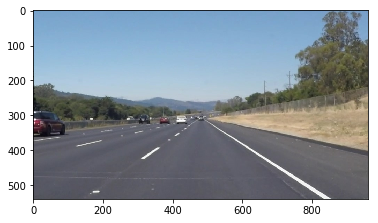

In [58]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Farbraum als Spielwiese 

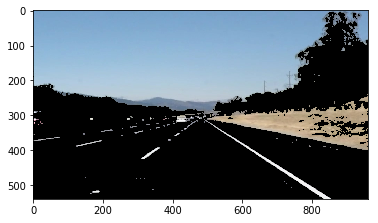

In [60]:
# Note: always make a copy rather than simply using "="
color_select = np.copy(image)

# Create RGB Threshold 
red_threshold = 0
green_threshold = 0
blue_threshold = 122
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Identify pixels below the threshold
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

# Display the image                 
plt.imshow(color_select)
plt.show()

## Ansätze für die Fahrspurerkennung 

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**You could check out the OpenCV documentation to learn about these and discover more functionality!**

## Hilfsfunktionen 

In [61]:
import math
from collections import deque
from collections import deque 

line_buffer = deque(maxlen=10)



def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane 
    """

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    
def draw_solid_lines(img, lines, color=[255, 0, 0], thickness=5):
    
    left_lane_color = [255,0,0] #red
    right_lane_color = [0,0,255] #blue
    right_lane=[]
    left_lane =[]
    
    right_slope=[]
    left_slope=[]
     
    
    eol = int(np.floor(540/2.0 + 50))
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if (slope >0):
                #right lane
                n = y1-slope*x1
                right_lane.append([slope, n])
            if (slope <0):
                #left lane
                n = y1-slope*x1
                left_lane.append([slope, n])

    ##draw lane for right side
    #calc mean of slope
    if  right_lane: #check if list is empty
        right_lane_mean = np.mean(right_lane,axis=0)
        slope = right_lane_mean[0]
        
        
        n = right_lane_mean[1]
        # Calc edge values for lines
        val_bol = int((540-n)/slope)
        val_eol = int((eol-n)/slope)
        cv2.line(img, (val_bol, 540), (val_eol, eol), right_lane_color, thickness)
    
    #draw lane for left side
    # take min_y for '0' and max_x as '1'points
    
    
    if  left_lane:   #check if list is empty
        left_lane_mean = np.mean(left_lane,axis=0)
        slope = left_lane_mean[0]
        n = left_lane_mean[1]
        # Calc edge values for line
        val_bol = int((540-n)/slope)
        val_eol = int((eol-n)/slope)
 
        cv2.line(img, (val_bol, 540), (val_eol, eol), left_lane_color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
  
    draw_lines(line_img, lines)
    #draw_solid_lines_1(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Testbilder
Testbilder sind im Verzeichnis  "test_images"  abgelegt.
Aus der 'os' Bibliothek könnt ihr über folgende Methode auf die Inhalte des Verzeichniss zugreifen 

In [62]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg']

## Pipeline zur Segmentierung der Fahrspurinformationen 



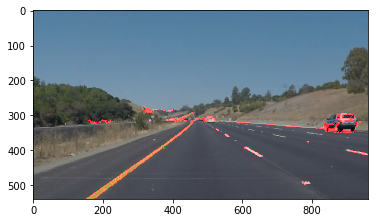

In [64]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

for filename in os.listdir("test_images/"): #assuming gif
    # Load frame
    name = "test_images/%s" % filename

    img=mpimg.imread(name)
    # Read images size
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    # This is your task !!
    # Convert to grayscale image (masked and full image)
    img_gray = grayscale(img)
    
        
    # Smooth image - reduce noise with kernel size (k)
    kernel_size = 7 # only odd numbers
    img_gray = gaussian_blur(img_gray, kernel_size)
    # plt.imshow(img_gray,cmap='gray')
    
    # Calc threshold with simple histogram calculation
    # Your Task specify a threshold to convert rgb to grayscale image 
    low_threshold  = 10
    high_threshold = 220
    
    # Get edges with canny kernel
    img_edge = canny(img_gray, low_threshold, high_threshold)
    
    # plt.imshow(img_edge,cmap='gray')
    
    
    # This is your task !!
    # Apply ROI
    left_bottom = [0, ysize]
    right_bottom = [xsize, ysize]
    apex_left = [np.floor(10), np.floor(ysize/2)]  # adjus apex left in height and width
    apex_right = [np.floor(xsize-10), np.floor(ysize/2)] # adjus apex right in height and width
    
    vertices = np.array([left_bottom,apex_left,apex_right,right_bottom],dtype = np.int32)
    img_crop = region_of_interest(img_edge, vertices)
    
    # plt.imshow(img_crop,cmap='gray')
    
    #apply hough transformation 
    rho = 1
    theta = np.pi/180
    threshold = 2 # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 4 # pixel 
    max_line_gap = 10 #pixel
    line_image = hough_lines(img_crop, rho, theta, threshold, min_line_len, max_line_gap)
    lines_edge = weighted_img(line_image, img)
    
    plt.imshow(lines_edge)
    # Save frame to specific folder
    
    
    cv2.imwrite("test_images_output/"+filename,lines_edge)
  


## Helpers helper
### Grayscale Image 
- hist_full = cv2.calcHist([img_gray],[0],None,[256],[1,256])
- peak = hist_full.argmax()
- low_threshold  = peak-50
- high_threshold = peak+50
### ROI
- left_bottom = [0, ysize]
- right_bottom = [xsize, ysize]
- apex_left = [np.floor(xsize/2)-50, np.floor(ysize/2)+60]
- apex_right = [np.floor(xsize/2)+50, np.floor(ysize/2)+60]

### Hough Transformation
- threshold = 20 # minimum number of votes (intersections in Hough grid cell)
- min_line_len = 40 # pixel 
- max_line_gap = 100 #pixel